100%|██████████| 50/50 [00:04<00:00, 10.30it/s]


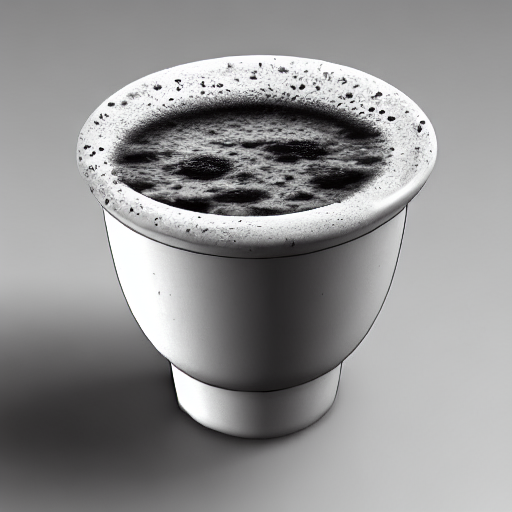

In [4]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32)
pipeline.to("cuda")
pipeline("a point cloud of a cup").images[0]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


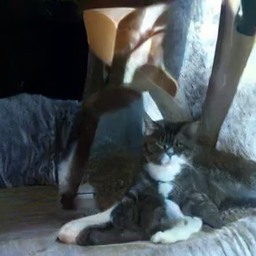

In [8]:
from diffusers import DDPMScheduler, UNet2DModel
from PIL import Image
import torch

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256").to("cuda")
scheduler.set_timesteps(1000)

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size), device="cuda")
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
        prev_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
        input = prev_noisy_sample

image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image

In [10]:
len(scheduler.timesteps)

1000

### Stable Diffusion

In [2]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

/home/hongyu/miniconda3/envs/diffusers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hongyu/miniconda3/envs/diffusers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [5]:
prompt = ["a point cloud of bottle"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.manual_seed(1)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [6]:
torch_device = "cpu"

In [7]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [8]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [9]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=torch_device,
)

In [10]:
latents = latents * scheduler.init_noise_sigma

In [11]:
scheduler.init_noise_sigma

1.0

In [1]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    # NOTE 我需要
    # 1. 把 text_embeddings 替换成 pc_embeddings
    # 2. latent_model_input 是噪声
    # 3. text_embeddings 的维度要和 pc_embeddings 一致，所以要找能产生一致 embedding 的CLIP encoder
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=torch.cat([text_embeddings]*2)).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

/home/hongyu/miniconda3/envs/diffusers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'scheduler' is not defined

In [13]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

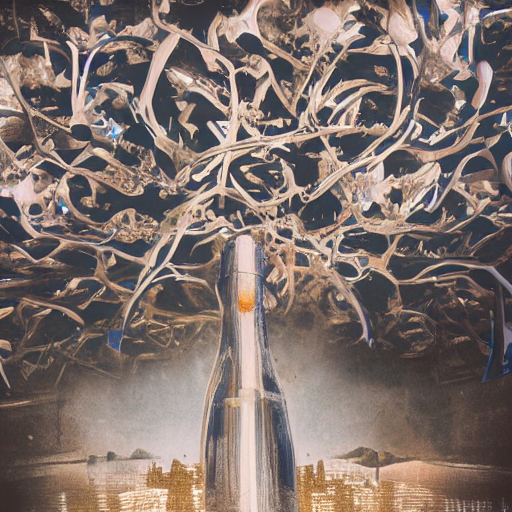

In [14]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image

### Load Schedulers and Models

In [29]:
from huggingface_hub import login
from diffusers import DiffusionPipeline
import torch

# login()

pipeline = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32, use_safetensors=True
)

Loading pipeline components...:  43%|████▎     | 3/7 [00:00<00:00,  5.51it/s]/home/hongyu/miniconda3/envs/diffusers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 11.97it/s]


In [30]:
pipeline.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.30.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [31]:
pipeline.scheduler.compatibles

[diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSDEScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.utils.dummy_torch_and_scipy_objects.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
 diffusers.schedulers.scheduling_edm_euler.EDMEulerScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
 diffus

In [32]:
pipeline.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('skip_prk_steps', True),
            ('set_alpha_to_one', False),
            ('prediction_type', 'epsilon'),
            ('timestep_spacing', 'leading'),
            ('steps_offset', 1),
            ('_use_default_values', ['timestep_spacing', 'prediction_type']),
            ('_class_name', 'PNDMScheduler'),
            ('_diffusers_version', '0.30.0'),
            ('clip_sample', False)])

In [42]:
prompt = "A point cloud of laptop on a table, high resolution, high definition."

In [43]:
from diffusers import EulerDiscreteScheduler

pipeline.scheduler = EulerDiscreteScheduler.from_config(pipeline.scheduler.config)

100%|██████████| 50/50 [01:54<00:00,  2.30s/it]


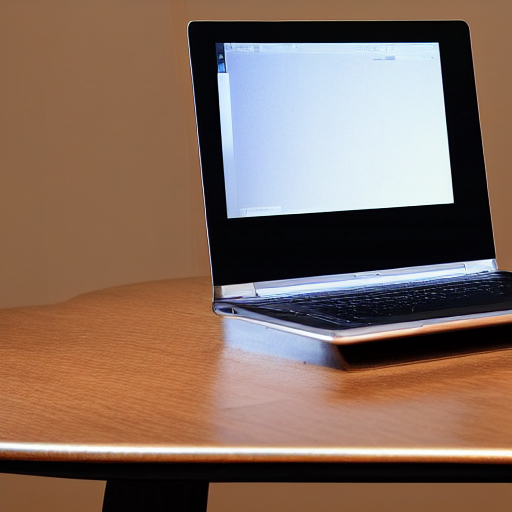

In [44]:
generator = torch.Generator(device="cpu").manual_seed(8)
image = pipeline(prompt, generator=generator).images[0]
image

### My Own Diffusion Model For PointCloud-to-Image Generation

In [2]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet")


/home/hongyu/miniconda3/envs/diffusers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hongyu/miniconda3/envs/diffusers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from diffusers import PNDMScheduler

scheduler = PNDMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)


In [6]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_features

#### define the parameters we'll use to generate images.

In [7]:
# prompt = ["a mesh of a table"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100           # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(0)    # Seed generator to create the inital latent noise

# batch_size = len(prompt)

batch_size = 1

In [8]:

# text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

# text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

text_embeddings = torch.load('owl_shape_feat.pt')
text_embeddings = torch.nn.functional.normalize(text_embeddings, dim=-1)*(768**0.5)/2
text_embeddings = text_embeddings.unsqueeze(1).repeat(1,2,1)
text_embeddings.shape

torch.Size([1, 2, 768])

In [9]:
# max_length = text_input.input_ids.shape[-1]
max_length = 1
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
uncond_embeddings.shape

torch.Size([1, 2, 768])

In [10]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
# text_embeddings = torch.cat([uncond_embeddings, uncond_embeddings])

In [11]:
text_embeddings.shape

torch.Size([2, 2, 768])

In [12]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)


/tmp/ipykernel_3135754/461901850.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [13]:
scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.init_noise_sigma


In [14]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample


100%|██████████| 109/109 [00:10<00:00, 10.02it/s]


In [15]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample


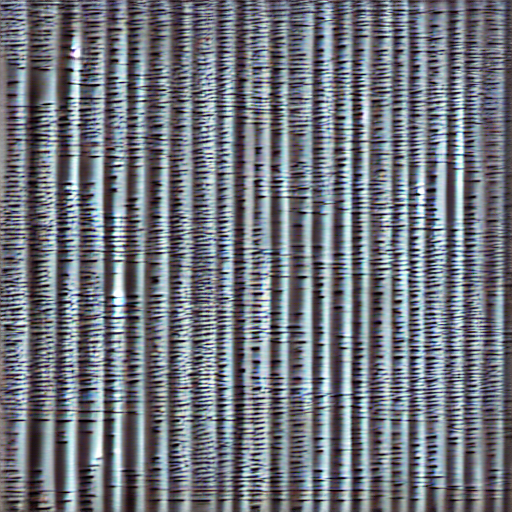

In [16]:
from PIL import Image

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]


### Stable Diffusion XL

In [1]:
from PIL import Image
import torch
from diffusers import DiffusionPipeline

/home/hongyu/miniconda3/envs/diffusers/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. load both base & refiner
base = DiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-xl-base-1.0', 
                                         torch_dtype=torch.float16, variant="fp16", use_safetensors=True)
base.to("cuda")

refiner = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-1.0",
                                            text_encoder_2=base.text_encoder_2, 
                                            vae=base.vae,
                                            torch_dtype=torch.float16,
                                            use_safetensors=True,
                                            variant="fp16",)
refiner.to("cuda")

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 53.39it/s]


StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.30.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-refiner-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": false,
  "image_encoder": [
    null,
    null
  ],
  "requires_aesthetics_score": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    null,
    null
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [10]:
# 2. Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 50
high_noise_frac = 0.75

prompt = "a single object of a table with clean background, centered in the figure"

In [11]:
# 3. run both experts
image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images
image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:04<00:00,  2.63it/s]


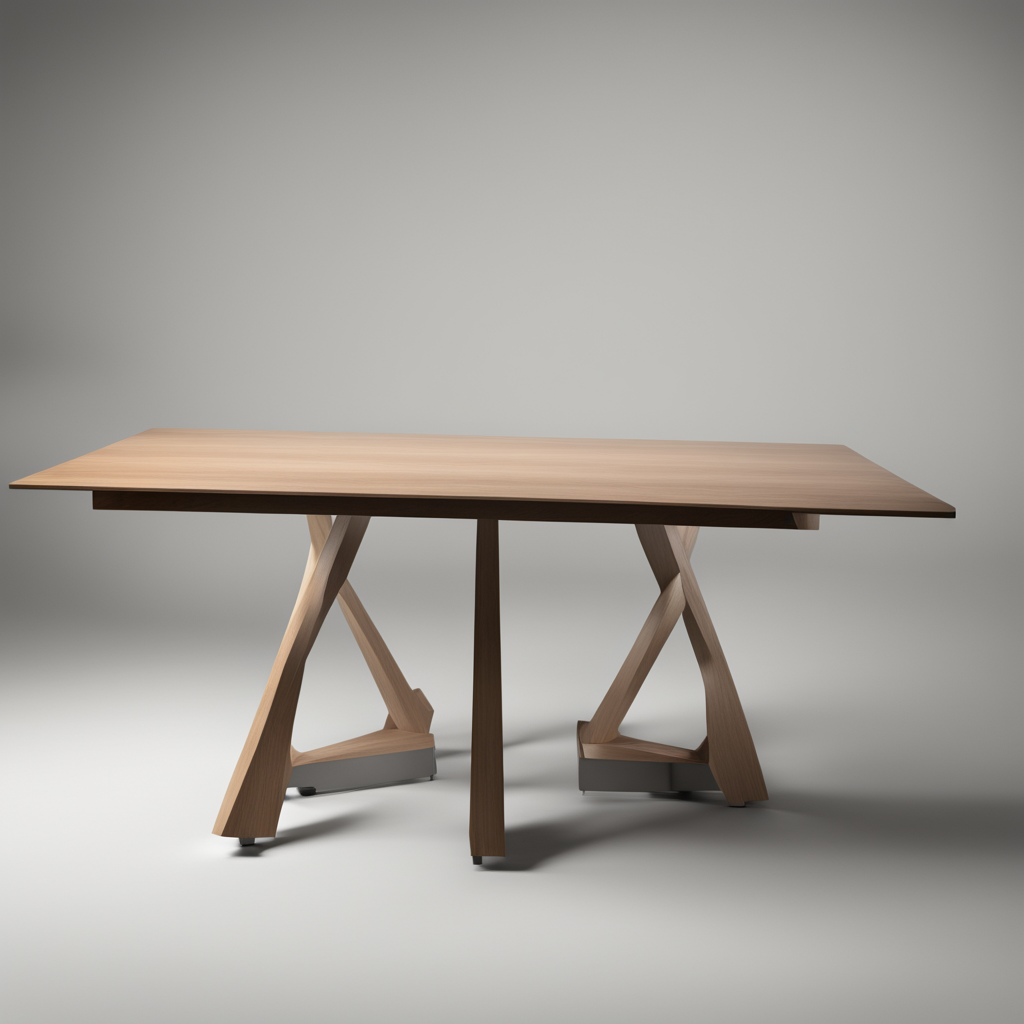

In [12]:
image

In [13]:
aaa = "tv_stand"
aaa = aaa.replace("_", " ")
print(aaa)

tv stand


: 

In [ ]:
### Resize 1024x1024 Image to 224x224

In [2]:
import torchvision.transforms as transforms
from PIL import Image

# Load your image
image_path = "../data/diffusion/modelnet_c/airplane/3.png"
image = Image.open(image_path)

# Define the transformation pipeline
transform_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor()           # Convert the image to a PyTorch tensor
])

# Apply the transformation pipeline
image_tensor = transform_pipeline(image)

# If you want to convert the tensor back to a PIL image (optional)
resized_image_pil = transforms.ToPILImage()(image_tensor)

# Save the resized image if needed
resized_image_pil.save("images/sdxl-resized_airplane.png")


### OpenShape 3D-conditioned Image Synthesis

In [4]:
import torch
import transformers
import torch_redstone as rst
from diffusers import StableUnCLIPImg2ImgPipeline

In [5]:
class Wrapper(transformers.modeling_utils.PreTrainedModel):
    def __init__(self) -> None:
        super().__init__(transformers.configuration_utils.PretrainedConfig())
        self.param = torch.nn.Parameter(torch.tensor(0.))

    def forward(self, x):
        return rst.ObjectProxy(image_embeds=x)

pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "diffusers/stable-diffusion-2-1-unclip-i2i-l",
    # variant="fp16",
    image_encoder = Wrapper()
)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]/home/hongyu/miniconda3/envs/diffusers/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 9/9 [00:00<00:00, 24.29it/s]
